In [1]:
from frozen.engine import FrozenBt
from frozen.factor import batch_calc
from frozen.factor.expression.operators import *
from frozen.utils import Universe, decorator

class FactorFactory(FrozenBt):

    def __init__(self):
        super().__init__(__vsc_ipynb_file__)

    def univ(self):
        universe = Universe(self.config)
        self.universe = universe.pool

    def prepare_data(self):

        data_definitions = [
            ("stock_daily_hfq", ("high", "low", "close", "pct_chg"), ("high", "low", "close", "returns")),
            ("stock_daily_fundamental", "pe_ttm", "pe")
            ]
        
        return self.dataloader.load_batch(data_definitions, self.universe, self.start_date_lookback, self.end_date)

    @decorator.factor
    def calc(self):

        str_list = []
        name_list = []

        str_list += ["cs_rank(ts_argmax(signedpower(where(returns < 0 ? ts_stddev(returns, 5) : close), 2.0), 5))"]
        name_list += ["alpha1"]

        str_list += ["where(ts_min(delta(close, 1), 5) > 0 ? delta(close, 1) : where((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (mul(delta(close, 1), -1))))"]
        name_list += ["alpha2"]

        wms = "(ts_max(high, 12) - close) / (ts_max(high, 12) - ts_min(low, 12)) * 100"
        roc = "(close - delay(close, 12)) / delay(close, 12)"
        bias = "close * ts_mean(close, 12) / ts_mean(close, 12) * 100"

        pe = "normalize(pe, 30)"
        wms = f"normalize({wms}, 30)"
        roc = f"normalize({roc}, 30)"
        bias = f"normalize({bias}, 30)"

        str_list += [f"{pe} * 0.0415 - {wms} * 0.1512 + {roc} * 0.1427 + {bias} * 0.6652"]
        name_list += ["alpha3"]

        alpha = batch_calc(str_list, name_list, self.prepare_data(), parallel=True)

        return alpha

/Users/lig/opt/anaconda3/envs/frozen-dev/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
factory = FactorFactory()

In [3]:
factory.calc()

Calculating factor:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


alpha1


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


alpha1  alpha2  alpha3
ticker    trade_date                        
000001.SZ 2014-10-15     1.0   -2.84     NaN
          2014-10-16     1.0   -2.84     NaN
          2014-10-17     2.0    5.68     NaN
          2014-10-20     3.0   -3.55     NaN
          2014-10-21     4.0    5.69     NaN
...                      ...     ...     ...
603369.SH 2014-10-13     NaN    0.21     NaN
          2014-10-14     NaN    0.01     NaN
603993.SH 2014-10-10     NaN    0.12     NaN
          2014-10-13     NaN   -0.00     NaN
          2014-10-14     NaN    0.14     NaN

[393884 rows x 3 columns]

✅ Successfully connected to database    🔗 Done!                                
Calculating factor:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


alpha1
🧊 Initializing FROZEN Backtest Framework...


Performing Backtest: 100%|██████████| 418/418 [00:04<00:00, 96.74it/s]


🔔 Warnings: Not consistent with date_rule for the last holding period.


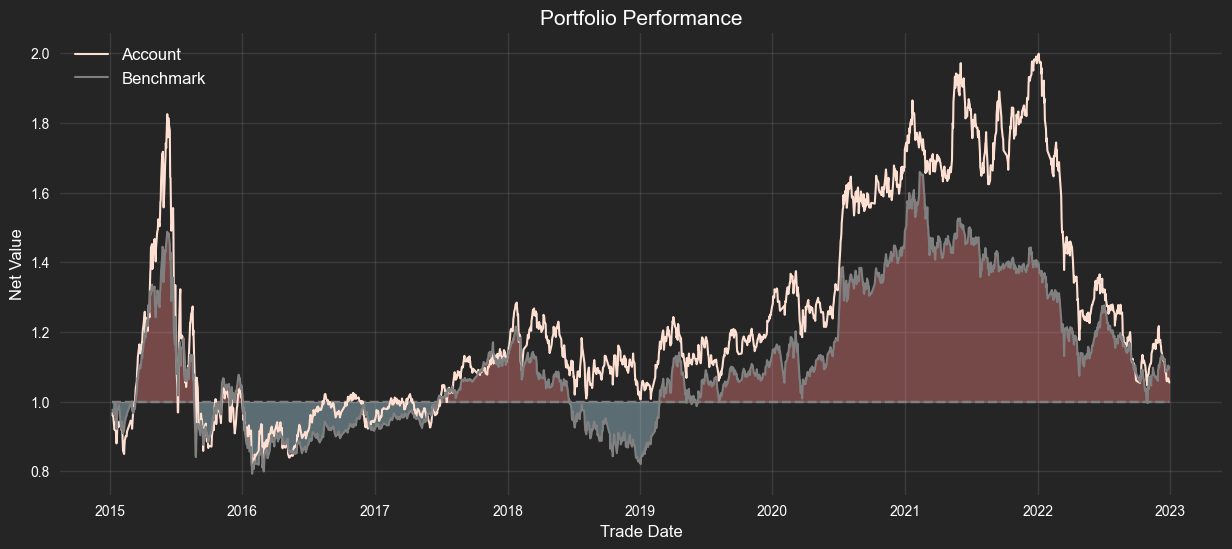

🧊 Initializing FROZEN Backtest Framework...


Performing Backtest: 100%|██████████| 418/418 [00:04<00:00, 93.09it/s]


🔔 Warnings: Not consistent with date_rule for the last holding period.


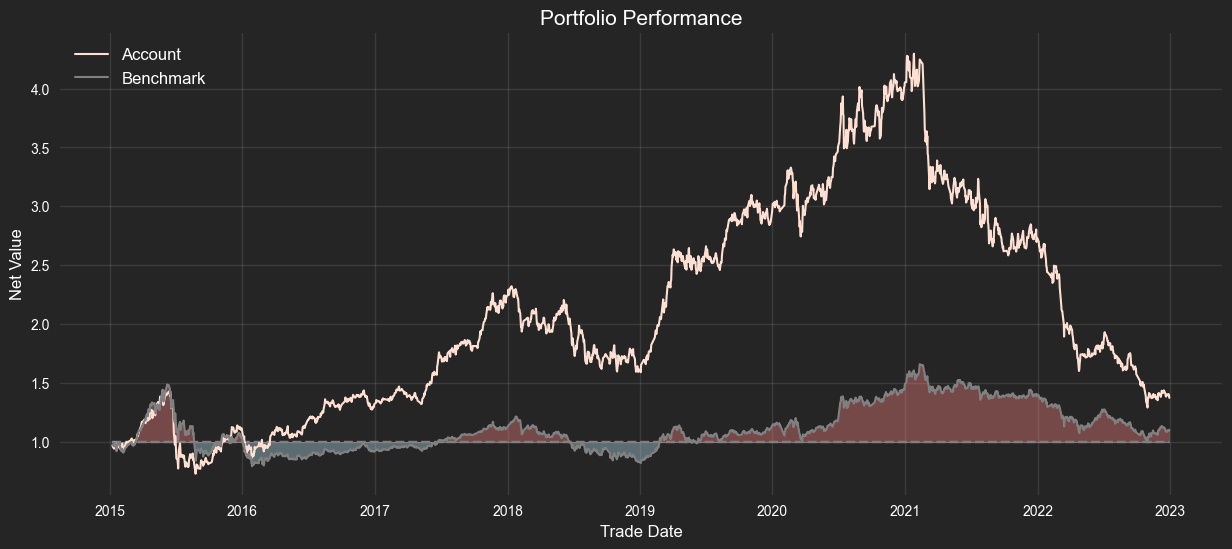

🧊 Initializing FROZEN Backtest Framework...


Performing Backtest: 100%|██████████| 418/418 [00:05<00:00, 82.39it/s]


🔔 Warnings: Not consistent with date_rule for the last holding period.


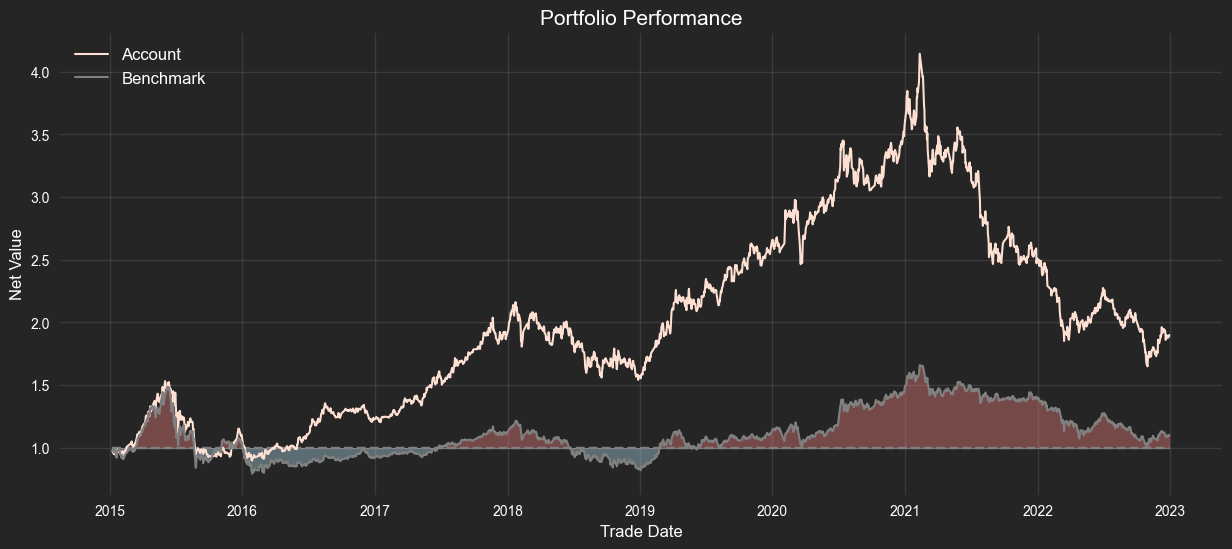

,Account,Benchmark,Annual Rate,Beta,Alpha,Sharpe,Sortino,IR,Win Rate,Max Drawdown
alpha1,1.0548,1.0989,0.0070,0.8986,-0.0041,0.1658,0.2286,0.0024,0.4826,0.5549
alpha2,1.3737,1.0989,0.0421,1.0287,0.0294,0.2884,0.4058,0.0160,0.4958,0.6993
alpha3,1.8994,1.0989,0.0869,0.9258,0.0755,0.4424,0.6256,0.0303,0.5012,0.6020


In [4]:
factory.run_batch(plot_type="line")